Data cleaning


In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import timedelta
from pandas import ExcelWriter

In [3]:
df=pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
#Missing values treatment

In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
df_null = round(df.isnull().sum()/len(df)*100,2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

As we can see two columns in data have missing values.

Description - 0.27% (1454 nos.)
CustomerID - 24.93% (135080)
CustomerID is important feature of our analysis since our analysis is centered around Customers only so we can not impute null values CustomerID with mean/ median/ mode in this case. We will check possibility to fill null values in CustomerID column by looking up for InvoiceNo of the row having null CustomerID in other rows where CustomerID is present. If there are still any null values in CustomerID after this process then we will drop complete row having missing CustomerID.

We can drop Description feature from our data since it is not not going to contribute in our model.

In [10]:
invoice_null_custid = set(df[df['CustomerID'].isnull()]['InvoiceNo'])
df[df['InvoiceNo'].isin(invoice_null_custid) & (~df['CustomerID'].isnull())]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [11]:
df = df.drop('Description', axis=1)
df = df.dropna()
df.shape

(406829, 7)

In [12]:
df = df.drop_duplicates()
df.shape

(401602, 7)

In [13]:
# CustomerID is 'float64', changing the datatype of CustomerId to string as Customer ID as numerical data does not make sense

df['CustomerID'] = df['CustomerID'].astype(str)

In [14]:
df.describe(datetime_is_numeric=True)

,Quantity,InvoiceDate,UnitPrice
count,401602.000000,401602,401602.000000
mean,12.182579,2011-07-10 12:08:08.129839872,3.474064
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-29 15:40:00,1.950000
75%,12.000000,2011-10-20 11:58:00,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,250.283248,NaN,69.764209


In [15]:
df.describe(include=['O'])

,InvoiceNo,StockCode,CustomerID,Country
count,401602,401602,401602,401602
unique,22190,3684,4372,37
top,576339,85123A,17841.0,United Kingdom
freq,542,2065,7812,356726


In [16]:
#Data transformation


In [17]:
#a) Create month cohort of customers and analyze active customers in each cohort:

In [18]:
# Convert to InvoiceDate to Year-Month format
df['month_year'] = df['InvoiceDate'].dt.to_period('M')
df['month_year'].nunique()

13

In [19]:
month_cohort = df.groupby('month_year')['CustomerID'].nunique()
month_cohort

month_year
2010-12     948
2011-01     783
2011-02     798
2011-03    1020
2011-04     899
2011-05    1079
2011-06    1051
2011-07     993
2011-08     980
2011-09    1302
2011-10    1425
2011-11    1711
2011-12     686
Freq: M, Name: CustomerID, dtype: int64

Text(0.5, 1.0, 'No. of active customers in each month')

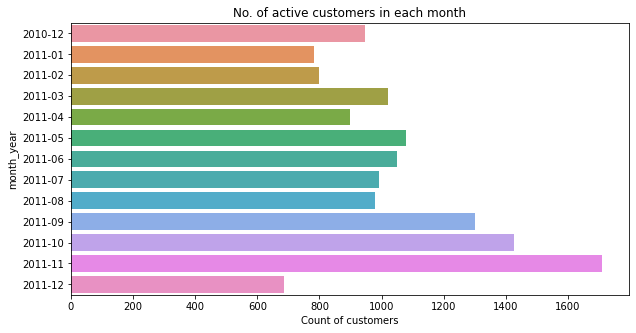

In [20]:
plt.figure(figsize=(10,5))
sns.barplot(y = month_cohort.index, x = month_cohort.values);
plt.xlabel("Count of customers")
plt.title("No. of active customers in each month")

In [21]:
month_cohort - month_cohort.shift(1)

month_year
2010-12       NaN
2011-01    -165.0
2011-02      15.0
2011-03     222.0
2011-04    -121.0
2011-05     180.0
2011-06     -28.0
2011-07     -58.0
2011-08     -13.0
2011-09     322.0
2011-10     123.0
2011-11     286.0
2011-12   -1025.0
Freq: M, Name: CustomerID, dtype: float64

In [22]:
retention_rate = round(month_cohort.pct_change(periods=1)*100,2)
retention_rate

month_year
2010-12      NaN
2011-01   -17.41
2011-02     1.92
2011-03    27.82
2011-04   -11.86
2011-05    20.02
2011-06    -2.59
2011-07    -5.52
2011-08    -1.31
2011-09    32.86
2011-10     9.45
2011-11    20.07
2011-12   -59.91
Freq: M, Name: CustomerID, dtype: float64

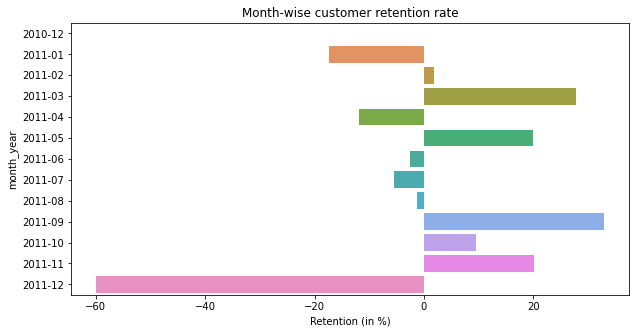

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(y = retention_rate.index, x = retention_rate.values);
plt.xlabel("Retention (in %)")
plt.title("Month-wise customer retention rate");

In [24]:
#week 2

In [25]:
#Monetary analysis

In [26]:
df['amount'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month_year,amount
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34


In [27]:
df_monetary = df.groupby('CustomerID').sum()['amount'].reset_index()
df_monetary

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2045.53


In [28]:
df_frequency = df.groupby('CustomerID').nunique()['InvoiceNo'].reset_index()
# df_freqency = df.drop_duplicates('InvoiceNo').groupby('CustomerID').count()['InvoiceNo'].reset_index()
df_frequency

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1
...,...,...
4367,18280.0,1
4368,18281.0,1
4369,18282.0,3
4370,18283.0,16


In [29]:
# We will fix reference date for calculating recency as last transaction day in data + 1 day
ref_day = max(df['InvoiceDate']) + timedelta(days=1)
df['days_to_last_order'] = (ref_day - df['InvoiceDate']).dt.days
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month_year,amount,days_to_last_order
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30,374
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,374
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00,374
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,374
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,374


In [30]:
df_recency = df.groupby('CustomerID')['days_to_last_order'].min().reset_index()
df_recency

,CustomerID,days_to_last_order
0,12346.0,326
1,12347.0,2
2,12348.0,75
3,12349.0,19
4,12350.0,310
...,...,...
4367,18280.0,278
4368,18281.0,181
4369,18282.0,8
4370,18283.0,4


In [32]:
df_rf = pd.merge(df_recency, df_frequency,  on='CustomerID', how='inner')
df_rfm = pd.merge(df_rf, df_monetary, on='CustomerID', how='inner')
df_rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


newest    2734
newer      588
medium     416
older      353
oldest     281
Name: recency_labels, dtype: int64

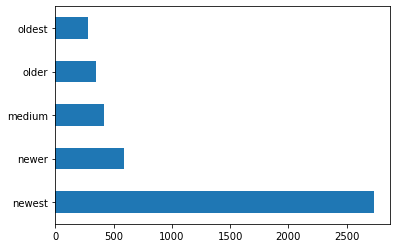

In [33]:
df_rfm['recency_labels'] = pd.cut(df_rfm['Recency'], bins=5,
                                     labels=['newest', 'newer', 'medium', 'older', 'oldest'])
df_rfm['recency_labels'].value_counts().plot(kind='barh');
df_rfm['recency_labels'].value_counts()

lowest     4348
lower        18
medium        3
highest       2
higher        1
Name: frequency_labels, dtype: int64

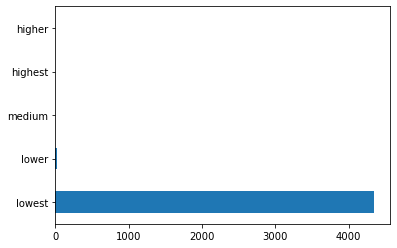

In [34]:
df_rfm['frequency_labels'] = pd.cut(df_rfm['Frequency'], bins=5, labels=['lowest', 'lower', 'medium', 'higher', 'highest'])
df_rfm['frequency_labels'].value_counts().plot(kind='barh');
df_rfm['frequency_labels'].value_counts()

smallest    4357
smaller        9
medium         3
largest        2
larger         1
Name: monetary_labels, dtype: int64

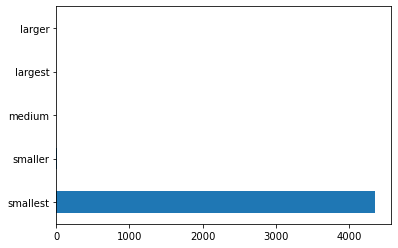

In [35]:
df_rfm['monetary_labels'] = pd.cut(df_rfm['Monetary'], bins=5, labels=['smallest', 'smaller', 'medium', 'larger', 'largest'])
df_rfm['monetary_labels'].value_counts().plot(kind='barh');
df_rfm['monetary_labels'].value_counts()

In [36]:
df_rfm['rfm_segment'] = df_rfm[['recency_labels','frequency_labels','monetary_labels']].agg('-'.join, axis=1)
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,recency_labels,frequency_labels,monetary_labels,rfm_segment
0,12346.0,326,2,0.00,oldest,lowest,smallest,oldest-lowest-smallest
1,12347.0,2,7,4310.00,newest,lowest,smallest,newest-lowest-smallest
2,12348.0,75,4,1797.24,newest,lowest,smallest,newest-lowest-smallest
3,12349.0,19,1,1757.55,newest,lowest,smallest,newest-lowest-smallest
4,12350.0,310,1,334.40,oldest,lowest,smallest,oldest-lowest-smallest


In [37]:
#RFM score

In [38]:
recency_dict = {'newest': 5, 'newer':4, 'medium': 3, 'older':2, 'oldest':1}
frequency_dict = {'lowest':1, 'lower':2, 'medium': 3, 'higher':4, 'highest':5}
monetary_dict = {'smallest':1, 'smaller':2, 'medium': 3, 'larger':4, 'largest':5}

df_rfm['rfm_score'] = df_rfm['recency_labels'].map(recency_dict).astype(int)+ df_rfm['frequency_labels'].map(frequency_dict).astype(int) + df_rfm['monetary_labels'].map(monetary_dict).astype(int)
df_rfm.head(10)

,CustomerID,Recency,Frequency,Monetary,recency_labels,frequency_labels,monetary_labels,rfm_segment,rfm_score
0,12346.0,326,2,0.00,oldest,lowest,smallest,oldest-lowest-smallest,3
1,12347.0,2,7,4310.00,newest,lowest,smallest,newest-lowest-smallest,7
2,12348.0,75,4,1797.24,newest,lowest,smallest,newest-lowest-smallest,7
3,12349.0,19,1,1757.55,newest,lowest,smallest,newest-lowest-smallest,7
4,12350.0,310,1,334.40,oldest,lowest,smallest,oldest-lowest-smallest,3
5,12352.0,36,11,1545.41,newest,lowest,smallest,newest-lowest-smallest,7
6,12353.0,204,1,89.00,medium,lowest,smallest,medium-lowest-smallest,5
7,12354.0,232,1,1079.40,older,lowest,smallest,older-lowest-smallest,4
8,12355.0,214,1,459.40,medium,lowest,smallest,medium-lowest-smallest,5
9,12356.0,23,3,2811.43,newest,lowest,smallest,newest-lowest-smallest,7


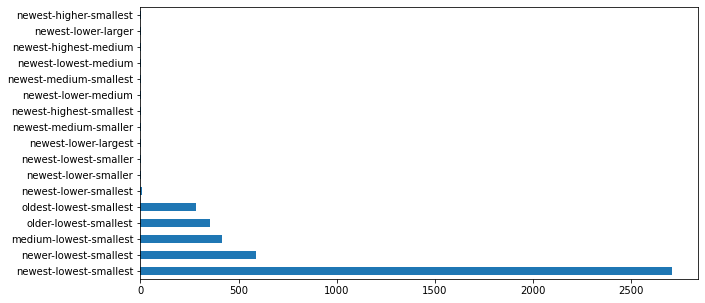

In [39]:
df_rfm['rfm_segment'].value_counts().plot(kind='barh', figsize=(10, 5));

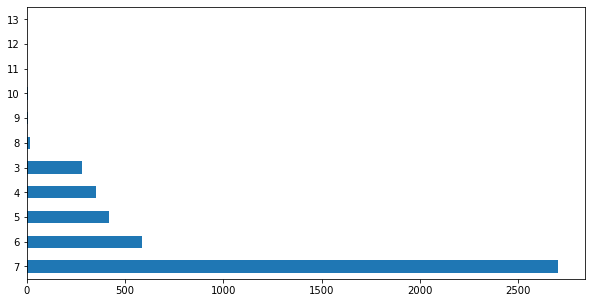

In [40]:
df_rfm['rfm_score'].value_counts().plot(kind='barh', figsize=(10, 5));

In [41]:
#week3

In [42]:
#Data Modelling

In [43]:
print(df_rfm.shape)
df_rfm.head()

(4372, 9)


,CustomerID,Recency,Frequency,Monetary,recency_labels,frequency_labels,monetary_labels,rfm_segment,rfm_score
0,12346.0,326,2,0.00,oldest,lowest,smallest,oldest-lowest-smallest,3
1,12347.0,2,7,4310.00,newest,lowest,smallest,newest-lowest-smallest,7
2,12348.0,75,4,1797.24,newest,lowest,smallest,newest-lowest-smallest,7
3,12349.0,19,1,1757.55,newest,lowest,smallest,newest-lowest-smallest,7
4,12350.0,310,1,334.40,oldest,lowest,smallest,oldest-lowest-smallest,3


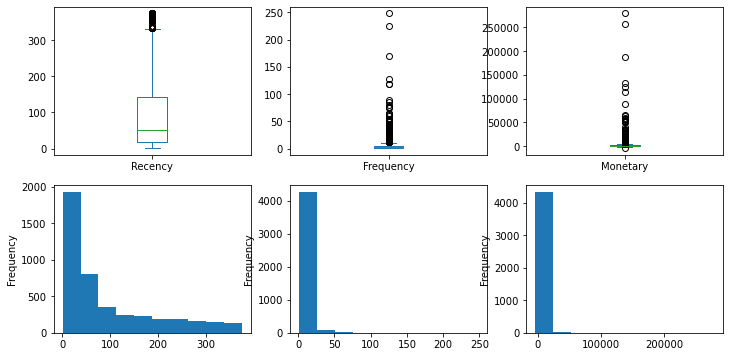

In [44]:
plt.figure(figsize=(12,6))

for i, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(2,3,i+1)
    df_rfm[feature].plot(kind='box')
    plt.subplot(2,3,i+1+3)
    df_rfm[feature].plot(kind='hist')

In [45]:
df_rfm = df_rfm[(df_rfm['Frequency']<60) & (df_rfm['Monetary']<40000)]
df_rfm.shape

(4346, 9)

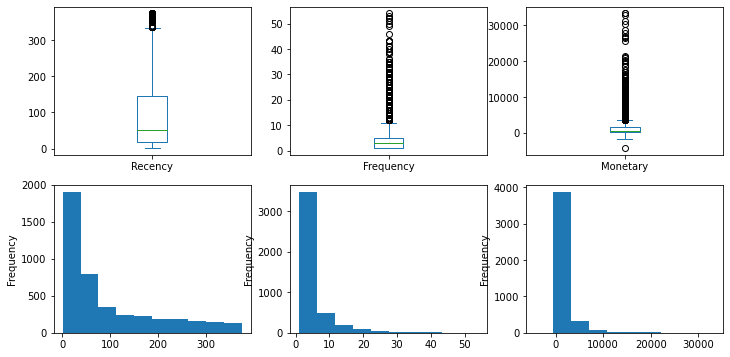

In [46]:
plt.figure(figsize=(12,6))

for i, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(2,3,i+1)
    df_rfm[feature].plot(kind='box')
    plt.subplot(2,3,i+1+3)
    df_rfm[feature].plot(kind='hist')

In [48]:
df_rfm_log_trans = pd.DataFrame()
df_rfm_log_trans['Recency'] = np.log(df_rfm['Recency'])
df_rfm_log_trans['Frequency'] = np.log(df_rfm['Frequency'])
df_rfm_log_trans['Monetary'] = np.log(df_rfm['Monetary']-df_rfm['Monetary'].min()+1)

**Standard Scalar Transformation:** It is extremely important to rescale the features so that they have a comparable scale.

In [50]:
scaler = StandardScaler()

df_rfm_scaled = scaler.fit_transform(df_rfm_log_trans[['Recency', 'Frequency', 'Monetary']])
df_rfm_scaled

df_rfm_scaled = pd.DataFrame(df_rfm_scaled)
df_rfm_scaled.columns = ['Recency', 'Frequency', 'Monetary']
df_rfm_scaled.head()

,Recency,Frequency,Monetary
0,1.402988,-0.388507,-0.770922
1,-2.100874,0.967301,1.485132
2,0.392218,0.361655,0.364190
3,-0.552268,-1.138669,0.342970
4,1.368370,-1.138669,-0.527416


Build K-Means Clustering Model and Decide the optimum number of clusters to be formed.

In [51]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(df_rfm_scaled)

C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [52]:
kmeans.labels_

array([0, 2, 1, ..., 1, 2, 1])

C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\harik\anaconda3\lib\site-packages\sklearn\clust

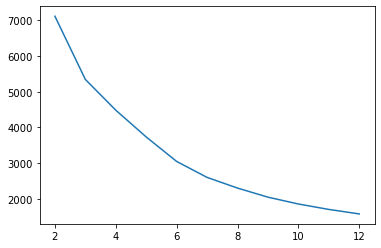

In [53]:
# Finding the Optimal Number of Clusters with the help of Elbow Curve/ SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
    kmeans.fit(df_rfm_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(range_n_clusters,ssd);

In [54]:
# Creating dataframe for exporting to create visualization in tableau later
df_inertia = pd.DataFrame(list(zip(range_n_clusters, ssd)), columns=['clusters', 'intertia'])
df_inertia

,clusters,intertia
0,2,7113.097396
1,3,5342.870670
2,4,4481.008711
3,5,3730.794415
4,6,3044.980596
5,7,2598.303803
6,8,2299.188049
7,9,2044.740060
8,10,1852.933027
9,11,1701.106980


In [55]:
# Finding the Optimal Number of Clusters with the help of Silhouette Analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for num_clusters in range_n_clusters:    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_rfm_scaled)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(df_rfm_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.44132753537785846


C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.37880537705682354


C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.3625879851651899


C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.36459931909000987


C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.34529262308119985


C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.3428878563127914


C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.3354671816479655


C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=9, the silhouette score is 0.3465372917153195


C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=10, the silhouette score is 0.3561039508340717


In [56]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(df_rfm_scaled)

C:\Users\harik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [57]:
# assign the label
df_rfm['Cluster_Id'] = kmeans.labels_
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,recency_labels,frequency_labels,monetary_labels,rfm_segment,rfm_score,Cluster_Id
0,12346.0,326,2,0.00,oldest,lowest,smallest,oldest-lowest-smallest,3,1
1,12347.0,2,7,4310.00,newest,lowest,smallest,newest-lowest-smallest,7,0
2,12348.0,75,4,1797.24,newest,lowest,smallest,newest-lowest-smallest,7,2
3,12349.0,19,1,1757.55,newest,lowest,smallest,newest-lowest-smallest,7,1
4,12350.0,310,1,334.40,oldest,lowest,smallest,oldest-lowest-smallest,3,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Monetary'>

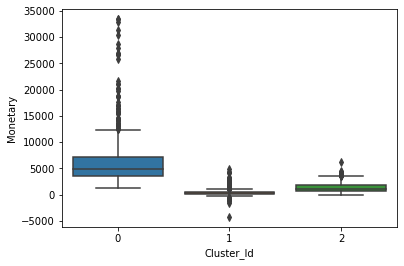

In [58]:
# Box plot to visualize Cluster Id vs Monetary
sns.boxplot(x='Cluster_Id', y='Monetary', data=df_rfm)

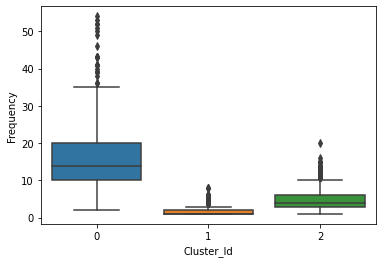

In [59]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=df_rfm);

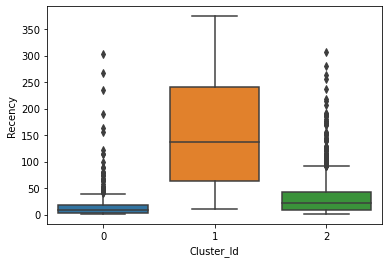

In [60]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=df_rfm);

In [64]:
# Writing dataframe to excel file for creating visualization in tableau
writer = pd.ExcelWriter('D:\work\Bootcamp capstone\Retail\output_data.xlsx', engine='xlsxwriter')

df.to_excel(writer, sheet_name='master_data', index=False)
df_rfm.to_excel(writer, sheet_name='rfm_data', index=False)
df_inertia.to_excel(writer, sheet_name='inertia', index=False)
writer.save()

In [65]:
product_desc = pd.read_excel("Online Retail.xlsx")
product_desc = product_desc[['StockCode', 'Description']]
product_desc = product_desc.drop_duplicates()
product_desc.to_csv('product_desc.csv', index=False)